<a href="https://colab.research.google.com/github/Kdavis2025/Automating-Compliance-AI-and-Machine-Learning-Approaches-to-Achieviing-CMMC-2.0-Certification/blob/main/Predictive_Cost_Analysis_for_SBEs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving cost_data.csv to cost_data (15).csv
Ridge CV RMSE: 21583.95
Lasso CV RMSE: 21586.74
Ridge Coefficients:
  Org_Size_Large: 7746.33
  Org_Size_Medium: 855.23
  Org_Size_Small: -8601.55
  Existing_Controls: 5463.61
  Historical_Costs: 2368.32
  CUI_Assets: 6840.57


<ipython-input-17-8aed8b4e24cb>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_coefficients, y=sorted_feature_names, palette='viridis')


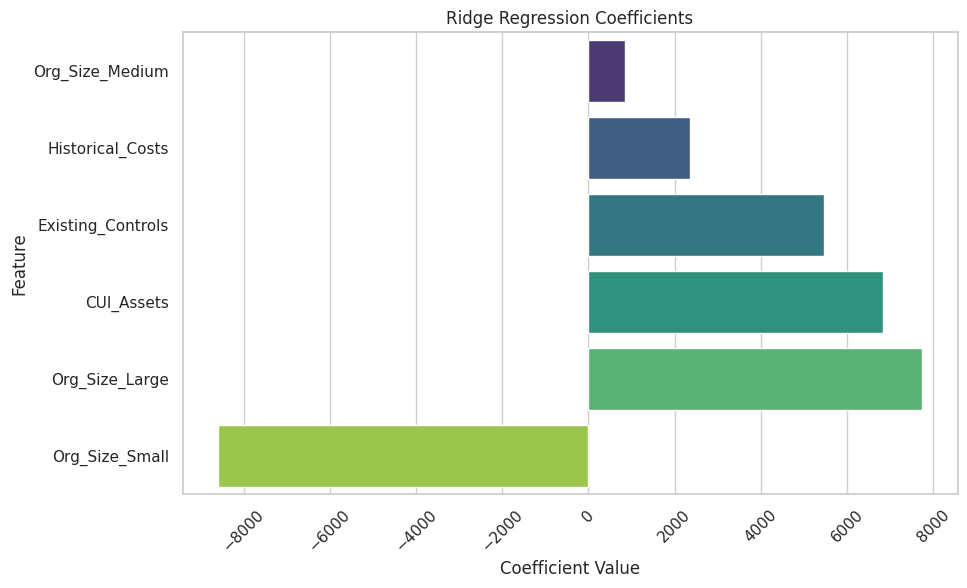

In [ ]:
# 1) Upload cost_data.csv from your local machine
from google.colab import files
uploaded = files.upload()  # choose cost_data.csv

# 2) Load the data
import pandas as pd
df = pd.read_csv('cost_data.csv')

# 3) Prepare features and target
X = df.drop(columns='Compliance_Cost')
y = df['Compliance_Cost']

# 4) Preprocessing: one-hot encode and scale
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ['Org_Size']
numeric_features = ['Existing_Controls', 'Historical_Costs', 'CUI_Assets']
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), categorical_features),
    ('scale', StandardScaler(), numeric_features)
])

# 5) Define Ridge and Lasso pipelines
from sklearn.linear_model import Ridge, Lasso

ridge_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', Ridge(alpha=1.0))
])
lasso_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', Lasso(alpha=0.1, max_iter=10000))
])

# 6) Cross-validation
from sklearn.model_selection import cross_val_score
import numpy as np

ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_scores = cross_val_score(lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

print(f'Ridge CV RMSE: {np.sqrt(-ridge_scores).mean():.2f}')
print(f'Lasso CV RMSE: {np.sqrt(-lasso_scores).mean():.2f}')

# 7) Train final model and inspect coefficients
ridge_pipeline.fit(X, y)
coef = ridge_pipeline.named_steps['model'].coef_
feature_names = (
    ridge_pipeline.named_steps['prep']
      .named_transformers_['onehot']
      .get_feature_names_out(categorical_features)
).tolist() + numeric_features

# Sort the coefficients by absolute value
sorted_indices = np.argsort(np.abs(coef))
sorted_coefficients = coef[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

#Bar Chart of Ridge Regression Coeff
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_coefficients, y=sorted_feature_names, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Ridge Regression Coefficients')

print('Ridge Coefficients:')
for name, c in zip(feature_names, coef):
    print(f'  {name}: {c:.2f}')